# Week 2 exercise

## MathXpert with tools integration

- Provides the freedom to explore all the models available from the providers
- Handling of multiple tools calling simultaneously
- Efficiently run tools in parallel
- Tool response, i.e. the `plot_function`, that does not require going back to the LLM
- Uses the inbuilt logging package to allow the control of the verbosity of the logging, set to a higher level, like INFO, to reduce the noisy output

In [3]:
import os
import json
import logging
from enum import StrEnum
from getpass import getpass
from types import SimpleNamespace
from typing import Callable

from dotenv import load_dotenv
from openai import OpenAI
import ipywidgets as widgets
from IPython.display import display, clear_output, Latex
import gradio as gr

load_dotenv(override=True)

True

In [4]:
logging.basicConfig(level=logging.WARNING)

logger = logging.getLogger('mathxpert')
logger.setLevel(logging.DEBUG)

## Free Cloud Providers

Grab your free API Keys from these generous sites:

- https://openrouter.ai/
- https://ollama.com/

>**NOTE**: If you do not have a key for any provider, simply press ENTER to move on

In [5]:
class Provider(StrEnum):
    OLLAMA = 'Ollama'
    OPENROUTER = 'OpenRouter'

clients: dict[Provider, OpenAI] = {}
models: dict[Provider, list[str]] = {
    Provider.OLLAMA: [],
    Provider.OPENROUTER: [],
}

DEFAULT_PROVIDER = Provider.OLLAMA

selection_state: dict[Provider, str | None] = {
    Provider.OLLAMA: 'gpt-oss:20b',
    Provider.OPENROUTER: 'openai/gpt-oss-20b:free',
}

def get_secret_in_google_colab(env_name: str) -> str:
    try:
      from google.colab import userdata
      return userdata.get(env_name)
    except Exception:
      return ''
      

def get_secret(env_name: str) -> str:
    '''Gets the value from the environment(s), otherwise ask the user for it if not set'''
    key = os.environ.get(env_name) or get_secret_in_google_colab(env_name)

    if not key:
        key = getpass(f'Enter {env_name}:').strip()

    if key:
        logger.info(f'✅ {env_name} provided')
    else:
        logger.warning(f'❌ {env_name} not provided')
    return key.strip()


if api_key := get_secret('OLLAMA_API_KEY'):
    clients[Provider.OLLAMA] = OpenAI(api_key=api_key, base_url='https://ollama.com/v1')

if api_key := get_secret('OPENROUTER_API_KEY'):
    clients[Provider.OPENROUTER] = OpenAI(api_key=api_key, base_url='https://openrouter.ai/api/v1')

available_providers = [str(p) for p in clients.keys()]

INFO:mathxpert:✅ OLLAMA_API_KEY provided
INFO:mathxpert:✅ OPENROUTER_API_KEY provided


In [6]:
selected_provider, selected_model, client = '', '', None


def get_desired_value_or_first_item(desire, options) -> str | None:
    logger.debug(f'Pick {desire} from {options}')
    selected = desire if desire in options else None
    if selected:
        return selected

    return options[0] if options else None
        
try:
    selected_provider = get_desired_value_or_first_item(DEFAULT_PROVIDER, available_providers)
    client = clients.get(selected_provider)
except Exception:
    logger.warning(f'❌ no provider configured and everything else from here will FAIL 🤦, I know you know this already.')

def load_models_if_needed(client: OpenAI, selected_provider):
    global selected_model, models

    if client and not models.get(selected_provider):
        logging.info(f'📡 Fetching {selected_provider} models...')
        
        models[selected_provider] = [model.id for model in client.models.list()]
        selected_model = get_desired_value_or_first_item(
            selection_state[selected_provider], 
            models[selected_provider],
        )

load_models_if_needed(client, selected_provider)

logger.info(f'ℹ️ Provider: {selected_provider} Model: {selected_model}, Client: {client}')

DEBUG:mathxpert:Pick Ollama from ['Ollama', 'OpenRouter']
DEBUG:mathxpert:Pick gpt-oss:20b from ['glm-4.6', 'kimi-k2:1t', 'qwen3-coder:480b', 'deepseek-v3.1:671b', 'gpt-oss:120b', 'gpt-oss:20b', 'qwen3-vl:235b']
INFO:mathxpert:ℹ️ Provider: Ollama Model: gpt-oss:20b, Client: <openai.OpenAI object at 0x11c2658b0>


## Prompt

In [7]:
def get_messages(question: str) -> list[dict[str, str]]:
    """Generate messages for the chat models."""

    system_prompt = r'''
    You are MathXpert, an expert Mathematician who makes math fun to learn by relating concepts to real 
    practical usage to whip up the interest in learners.
    
    Explain step-by-step thoroughly how to solve a math problem. 
    - ALWAYS use `$$...$$` for mathematical expressions.
    - NEVER use square brackets `[...]` to delimit math.
    - Example: Instead of "[x = 2]", write "$$x = 2$$".
    - You may use `\\[4pt]` inside matrices for spacing.
    '''

    return [
        {'role': 'system', 'content': system_prompt },
        {'role': 'user', 'content': question},
    ]

## Tools

### Tools Definitions

In [8]:
from pydantic import BaseModel, Field
from openai.types.shared_params import FunctionDefinition
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import io
import base64
import random

class ToolInput(BaseModel):
    pass
    
class GetCurrentDateTimeInput(ToolInput):
    timezone: str = Field(default="UTC", description="Timezone name, e.g., 'UTC' or 'Africa/Accra'")


def get_current_datetime(req: GetCurrentDateTimeInput):
    '''Returns the current date and time in the specified timezone.'''
    from zoneinfo import ZoneInfo

    try:
        from datetime import datetime
        tz = ZoneInfo(req.timezone)
        dt = datetime.now(tz)
        return {
            "date": dt.strftime("%Y-%m-%d"),
            "time": dt.strftime("%H:%M:%S %Z"),
        } 
    except:
        return {"error": f"Invalid timezone: {req.timezone}"}


class GetTemperatureInput(ToolInput):
    pass

def get_temperature(req: GetTemperatureInput) -> float:
    '''Returns the current temperature in degree celsius'''
    return random.randint(-30, 70)


class PlotFunctionInput(ToolInput):
    expression: str = Field(description="Mathematical expression to plot, e.g., 'sin(x)'")
    x_min: float = Field(default=-10, description="Minimum x value")
    x_max: float = Field(default=10, description="Maximum x value")


def plot_function(req: PlotFunctionInput) -> dict[str, any]:
    '''Plots a mathematical function and returns image data.'''
    try:
        x = sp.symbols('x')
        expr = sp.sympify(req.expression)
        lambdified = sp.lambdify(x, expr, 'numpy')
        
        x_vals = np.linspace(req.x_min, req.x_max, 400)
        y_vals = lambdified(x_vals)
        
        plt.figure(figsize=(10, 6))
        plt.plot(x_vals, y_vals, 'b-', linewidth=2)
        plt.grid(True, alpha=0.3)
        plt.title(f"Plot of ${sp.latex(expr)}$", fontsize=14)
        plt.xlabel('x', fontsize=12)
        plt.ylabel('f(x)', fontsize=12)
        

        buf = io.BytesIO()
        plt.savefig(buf, format='png', dpi=100, bbox_inches='tight')
        plt.close()
        buf.seek(0)
        img_str = base64.b64encode(buf.read()).decode()
        
        return {
            "plot_image": f"data:image/png;base64,{img_str}",
            "expression": req.expression,
            "x_range": [req.x_min, req.x_max]
        }
    except Exception as e:
        return {"error": f"Could not plot function: {str(e)}"}



### Tools registration & execution

In [9]:
from concurrent.futures import ThreadPoolExecutor

class ToolManager:
    def __init__(self):
        self._tools = []
        self._tools_map: dict[str, tuple[Callable, ToolInput]] = {}

    def register_tool[T: ToolInput](self, fn: Callable, fn_input: T):
        self._tools.append({
            "type": "function",
            "function": FunctionDefinition(
                name=fn.__name__,
                description=fn.__doc__,
                parameters=fn_input.model_json_schema() if fn_input else None,
            )
        })
    
        self._tools_map[fn.__name__] = (fn, fn_input)

    def _run_single_tool(self, tool_call) -> dict[str, str] | None:
        if not tool_call.id:
            return None
    
        fn, fn_input = self._tools_map.get(tool_call.function.name)
        args = tool_call.function.arguments
        try:
            if args:
                result = fn(fn_input(**json.loads(args))) if fn_input else fn()
            else:
                result = fn(fn_input()) if fn_input else fn()
    
            logger.debug(f'Tool run result: {result}')
    
            return {
                'role': 'tool',
                'tool_call_id': tool_call.id,
                'content': json.dumps(result),
            }
        except Exception as e:
            logger.error(f'Tool execution failed: {e}', extra={'name': tool_call.function.name})
            return None

    def run(self, tool_calls) -> list[dict[str, str]]:
        if not tool_calls:
            return []

        logger.debug(tool_calls)

        tool_messages = []
        
        with ThreadPoolExecutor() as executor:
            futures = [executor.submit(self._run_single_tool, tool_call) for tool_call in tool_calls]
            
            for future in futures:
                result = future.result()
                if result:
                    tool_messages.append(result)
        
        return tool_messages

    @property
    def tools(self) -> list[any]:
        return self._tools

    def dump_tools(self) -> str:
        return json.dumps(self._tools, indent=True)

    
tool_manager = ToolManager()

tool_manager.register_tool(get_current_datetime, GetCurrentDateTimeInput)
tool_manager.register_tool(get_temperature, GetTemperatureInput)
tool_manager.register_tool(plot_function, PlotFunctionInput)

In [10]:
logger.debug(tool_manager.dump_tools())

DEBUG:mathxpert:[
 {
  "type": "function",
  "function": {
   "name": "get_current_datetime",
   "description": "Returns the current date and time in the specified timezone.",
   "parameters": {
    "properties": {
     "timezone": {
      "default": "UTC",
      "description": "Timezone name, e.g., 'UTC' or 'Africa/Accra'",
      "title": "Timezone",
      "type": "string"
     }
    },
    "title": "GetCurrentDateTimeInput",
    "type": "object"
   }
  }
 },
 {
  "type": "function",
  "function": {
   "name": "get_temperature",
   "description": "Returns the current temperature in degree celsius",
   "parameters": {
    "properties": {},
    "title": "GetTemperatureInput",
    "type": "object"
   }
  }
 },
 {
  "type": "function",
  "function": {
   "name": "plot_function",
   "description": "Plots a mathematical function and returns image data.",
   "parameters": {
    "properties": {
     "expression": {
      "description": "Mathematical expression to plot, e.g., 'sin(x)'",
      

## Interaction with LLM

In [11]:
# handle = display(None, display_id=True)

def ask(client: OpenAI | None, model: str, question: str, max_tool_turns=5):
    if client is None:
        logger.warning('You should have provided the API Keys you know. Fix 🔧 this and try again ♻️.')
        return

    try:
        logger.debug(f'# Tools: {len(tool_manager.tools)}')

        messages = get_messages(question=question)

        for turn in range(max_tool_turns):
            logger.debug(f'Turn: {turn}')
            response = client.chat.completions.create(
                model=model,
                messages=messages,
                tools=tool_manager.tools,
                stream=True,
            )
    
            current_message = {}
            tool_calls_accumulator = {}
            
            output = ''
            call_id = None
            
            for chunk in response:
                delta = chunk.choices[0].delta

                logger.debug(f' ✨  {chunk.choices[0]}')
                if content := delta.content:
                    output += content
                    yield output

                if tool_calls := delta.tool_calls:
                    for tool_chunk in tool_calls:
                        print('x' * 50)
                        print(tool_chunk)

                        if tool_chunk.id and call_id != tool_chunk.id:
                            call_id = tool_chunk.id

                        print(f'Call ID: {call_id}')
                        # Streams of arguments don't come with the call id
                        # if not call_id:
                        #     continue

                        if call_id not in tool_calls_accumulator:
                            # tool_calls_accumulator[call_id] = {
                            #     'id': call_id,
                            #     'function': {'name': '', 'arguments': ''}
                            # }
                            tool_calls_accumulator[call_id] = SimpleNamespace(
                                id=call_id,
                                function=SimpleNamespace(name='', arguments='')
                            )

                        if tool_chunk.function.name:
                            tool_calls_accumulator[call_id].function.name += tool_chunk.function.name
                            
                        if tool_chunk.function.arguments:
                            tool_calls_accumulator[call_id].function.arguments += tool_chunk.function.arguments

            if finish_reason := chunk.choices[0].finish_reason:
                logger.debug('🧠 LLM interaction ended. Reason: {finish_reason}')

            final_tool_calls = list(tool_calls_accumulator.values())
            if final_tool_calls:
                logger.debug(f'Final tools to call {final_tool_calls}')

                tool_call_message = {
                    'role': 'assistant',
                    'content': None,
                    'tool_calls': json.loads(json.dumps(final_tool_calls, default=lambda o: o.__dict__))
                }

                messages.append(tool_call_message)
                tool_messages = tool_manager.run(final_tool_calls)

                if tool_messages:
                    for tool_msg in tool_messages:
                        try:
                            data = json.loads(tool_msg['content'])
                            if 'plot_image' in data:
                                logger.debug('We have a plot')
                                yield f'<img src="{data["plot_image"]}" style="max-width: 100%; height: auto; border: 1px solid #ccc; border-radius: 5px;">'
                                return
                        except:
                            pass
                    messages.extend(tool_messages)
            else:
                return
                       
    except Exception as e:
        logger.error(f'🔥 An error occurred during the interaction with the LLM: {e}', exc_info=True)
        return str(e)

### Verify streaming behaviour

DEBUG:mathxpert:# Tools: 3
DEBUG:mathxpert:Turn: 0
DEBUG:mathxpert: ✨  Choice(delta=ChoiceDelta(content=None, function_call=None, refusal=None, role='assistant', tool_calls=None), finish_reason=None, index=0, logprobs=None)
DEBUG:mathxpert: ✨  Choice(delta=ChoiceDelta(content=None, function_call=None, refusal=None, role=None, tool_calls=None, reasoning_content='The'), finish_reason=None, index=0, logprobs=None)
DEBUG:mathxpert: ✨  Choice(delta=ChoiceDelta(content=None, function_call=None, refusal=None, role=None, tool_calls=None, reasoning_content=' user'), finish_reason=None, index=0, logprobs=None)
DEBUG:mathxpert: ✨  Choice(delta=ChoiceDelta(content=None, function_call=None, refusal=None, role=None, tool_calls=None, reasoning_content=' wants'), finish_reason=None, index=0, logprobs=None)
DEBUG:mathxpert: ✨  Choice(delta=ChoiceDelta(content=None, function_call=None, refusal=None, role=None, tool_calls=None, reasoning_content=' a'), finish_reason=None, index=0, logprobs=None)
DEBUG:ma

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
ChoiceDeltaToolCall(index=0, id='call_gUaf9cCr8Mn2s5zdix8L3ij2', function=ChoiceDeltaToolCallFunction(arguments=None, name='plot_function'), type='function')
Call ID: call_gUaf9cCr8Mn2s5zdix8L3ij2
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
ChoiceDeltaToolCall(index=0, id=None, function=ChoiceDeltaToolCallFunction(arguments='{"', name=None), type='function')
Call ID: call_gUaf9cCr8Mn2s5zdix8L3ij2
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
ChoiceDeltaToolCall(index=0, id=None, function=ChoiceDeltaToolCallFunction(arguments='expression', name=None), type='function')
Call ID: call_gUaf9cCr8Mn2s5zdix8L3ij2
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
ChoiceDeltaToolCall(index=0, id=None, function=ChoiceDeltaToolCallFunction(arguments='":"', name=None), type='function')
Call ID: call_gUaf9cCr8Mn2s5zdix8L3ij2
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
ChoiceDeltaToolCall(index=0, id=None, function=ChoiceDeltaTool

DEBUG:mathxpert:Tool run result: {'plot_image': '', 'expression': 'x**2', 'x_range': [-10, 10]}
DEBUG:mathxpert:We have a plot

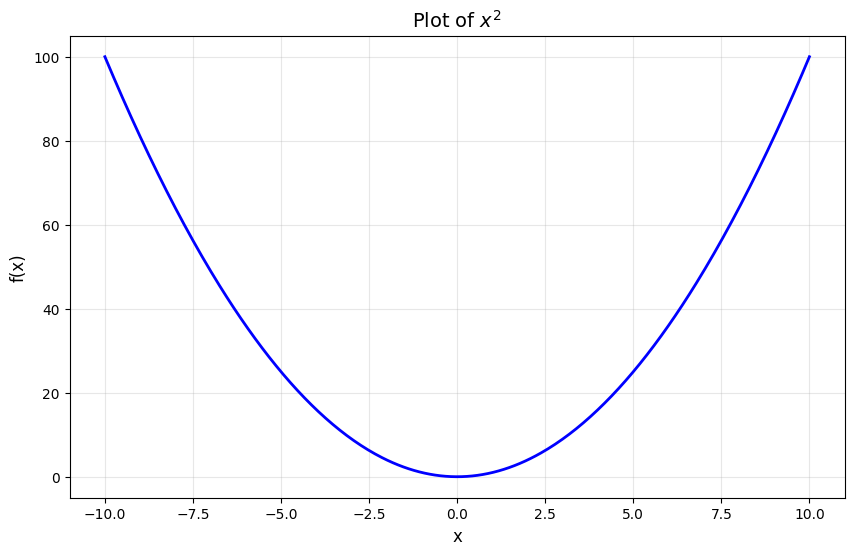



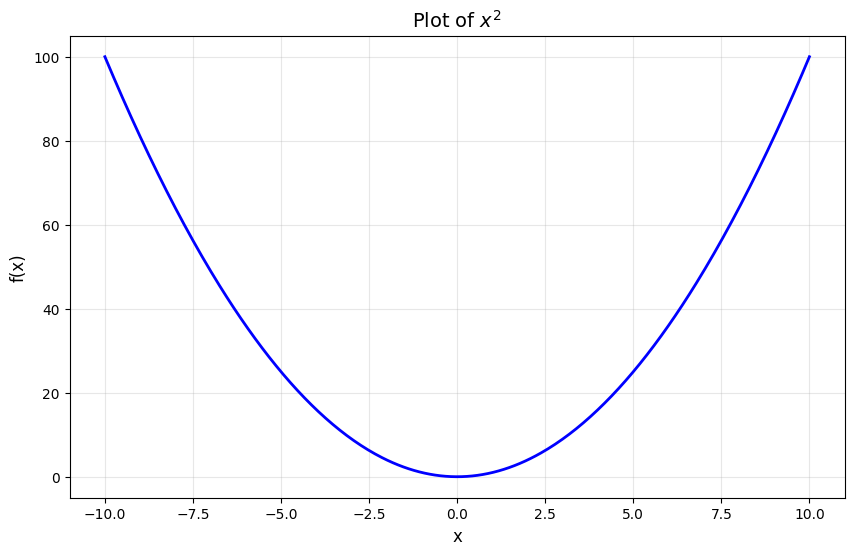

In [12]:
# print(selected_provider, selected_model)
# print(client)
# for o in ask(client, selected_model, 'What is the time?'):
# for o in ask(client, selected_model, 'What is the temperature?'):
# for o in ask(client, selected_model, 'What is the time and the temperature?'):
# for o in ask(client, selected_model, 'Plot a for the expression sin(x)'):
for o in ask(client, selected_model, 'Plot a graph of y = x**2'):
    print(o)

## Build Gradio UI

DEBUG:mathxpert:Pick Ollama from ['Ollama', 'OpenRouter']
DEBUG:mathxpert:Pick gpt-oss:20b from ['glm-4.6', 'kimi-k2:1t', 'qwen3-coder:480b', 'deepseek-v3.1:671b', 'gpt-oss:120b', 'gpt-oss:20b', 'qwen3-vl:235b']


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


DEBUG:mathxpert:# Tools: 3
DEBUG:mathxpert:Turn: 0
DEBUG:mathxpert: ✨  Choice(delta=ChoiceDelta(content=None, function_call=None, refusal=None, role='assistant', tool_calls=None), finish_reason=None, index=0, logprobs=None)
DEBUG:mathxpert: ✨  Choice(delta=ChoiceDelta(content=None, function_call=None, refusal=None, role=None, tool_calls=None, reasoning_content='User'), finish_reason=None, index=0, logprobs=None)
DEBUG:mathxpert: ✨  Choice(delta=ChoiceDelta(content=None, function_call=None, refusal=None, role=None, tool_calls=None, reasoning_content=' wants'), finish_reason=None, index=0, logprobs=None)
DEBUG:mathxpert: ✨  Choice(delta=ChoiceDelta(content=None, function_call=None, refusal=None, role=None, tool_calls=None, reasoning_content=' to'), finish_reason=None, index=0, logprobs=None)
DEBUG:mathxpert: ✨  Choice(delta=ChoiceDelta(content=None, function_call=None, refusal=None, role=None, tool_calls=None, reasoning_content=' plot'), finish_reason=None, index=0, logprobs=None)
DEBUG:

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
ChoiceDeltaToolCall(index=0, id='call_EAUjPtptsIVT7yUFY7KMYVZ9', function=ChoiceDeltaToolCallFunction(arguments=None, name='plot_function'), type='function')
Call ID: call_EAUjPtptsIVT7yUFY7KMYVZ9
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
ChoiceDeltaToolCall(index=0, id=None, function=ChoiceDeltaToolCallFunction(arguments='{"', name=None), type='function')
Call ID: call_EAUjPtptsIVT7yUFY7KMYVZ9
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
ChoiceDeltaToolCall(index=0, id=None, function=ChoiceDeltaToolCallFunction(arguments='expression', name=None), type='function')
Call ID: call_EAUjPtptsIVT7yUFY7KMYVZ9
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
ChoiceDeltaToolCall(index=0, id=None, function=ChoiceDeltaToolCallFunction(arguments='":"', name=None), type='function')
Call ID: call_EAUjPtptsIVT7yUFY7KMYVZ9
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
ChoiceDeltaToolCall(index=0, id=None, function=ChoiceDeltaTool

DEBUG:mathxpert:🧠 LLM interaction ended. Reason: {finish_reason}
DEBUG:mathxpert:Final tools to call [namespace(id='call_EAUjPtptsIVT7yUFY7KMYVZ9', function=namespace(name='plot_function', arguments='{"expression":"x**2 - 3*x","x_min":-10,"x_max":10}'))]
DEBUG:mathxpert:[namespace(id='call_EAUjPtptsIVT7yUFY7KMYVZ9', function=namespace(name='plot_function', arguments='{"expression":"x**2 - 3*x","x_min":-10,"x_max":10}'))]
DEBUG:mathxpert:Tool run result: {'plot_image': '', 'expression': 'x**2 - 3*x', 'x_range': [-10.0, 10.0]}
DEBUG:mathxpert:We have a plot

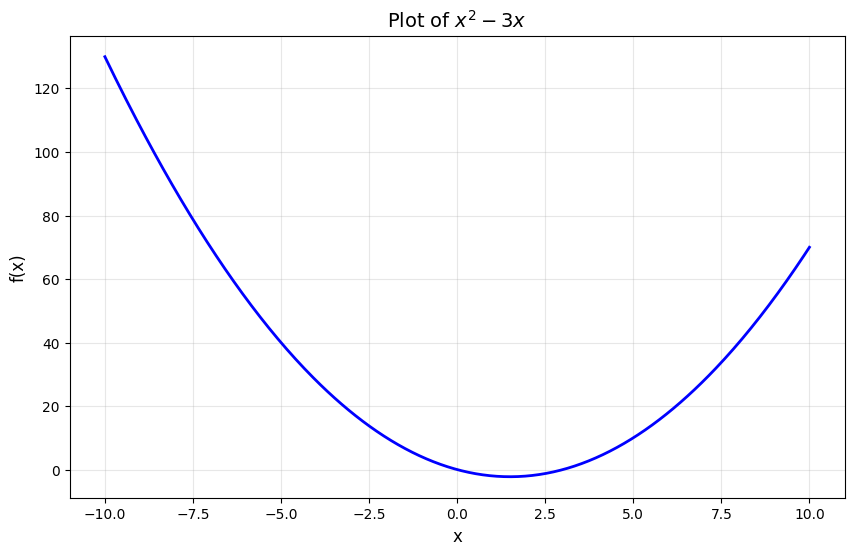

In [13]:
def chat(message: str, history: list[dict], selected_provider: str, model_selector: str):
    # NOTE: I'm not interesting in maintaining a conversation
    response = ask(client, selected_model, message)

    for chunk in response:
        yield chunk

def on_provider_change(change):
    global selected_provider, client, models
    logger.info(f'Provider changed to {change}')
    selected_provider = change
    client = clients.get(selected_provider)
    load_models_if_needed(client, selected_provider)

    return gr.Dropdown(
        choices=models.get(selected_provider, []),
        value=selection_state[selected_provider],
        interactive=True,
    )


def on_model_change(change):
    global selected_provider, selected_model, selection_state

    selected_model = change
    selection_state[selected_provider] = selected_model
    logger.info(f'👉 Selected model: {selected_model}')


with gr.Blocks(title='MathXpert', fill_width=True,  
    
  ) as ui:
    def get_value_if_exist(v, ls) -> str:
        print(ls)
        selected = v if v in ls else None
        if selected:
            return selected

        return ls[0] if ls else None

    with gr.Row():
        provider_selector = gr.Dropdown(
            choices=available_providers, 
            value=get_desired_value_or_first_item(selected_provider, available_providers),
            label='Provider',
        )
        model_selector = gr.Dropdown(
            choices=models[selected_provider],
            value=get_desired_value_or_first_item(selection_state[selected_provider], models[selected_provider]),
            label='Model',
        )
    
    provider_selector.change(fn=on_provider_change, inputs=provider_selector, outputs=model_selector)
    model_selector.change(fn=on_model_change, inputs=model_selector)

    examples = [
        ['Where can substitutions be applied in real life?', None, None],
        ['Give 1 differential equation question and solve it', None, None],
        ['Plot x**2 - 3x', None, None],
        ['What is the time now?', None, None],
        ['What is the temperature?', None, None],
        ['Tell me the time and the temperature now', None, None],
    ]

        
    gr.ChatInterface(
        fn=chat, 
        type='messages', 
        chatbot=gr.Chatbot(type='messages', height='75vh', resizable=True),
        additional_inputs=[provider_selector, model_selector],
        examples=examples,
    )

ui.launch()